In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/

/content/drive


In [ ]:
### ONLY RUN ONCE
# # Step 2: Extract the ZIP into the proper folder
# import zipfile
# import os

# zip_path = "/content/drive/MyDrive/CSCI566/data/dl_data_final.zip"
# extract_path = "/content/drive/MyDrive/DL 3D Resnet Findings"

# # Create the extract directory if it doesn't exist
# os.makedirs(extract_path, exist_ok=True)

# # Unzip
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("✅ Extracted to:", extract_path)


✅ Extracted to: /content/drive/MyDrive/DL 3D Resnet Findings


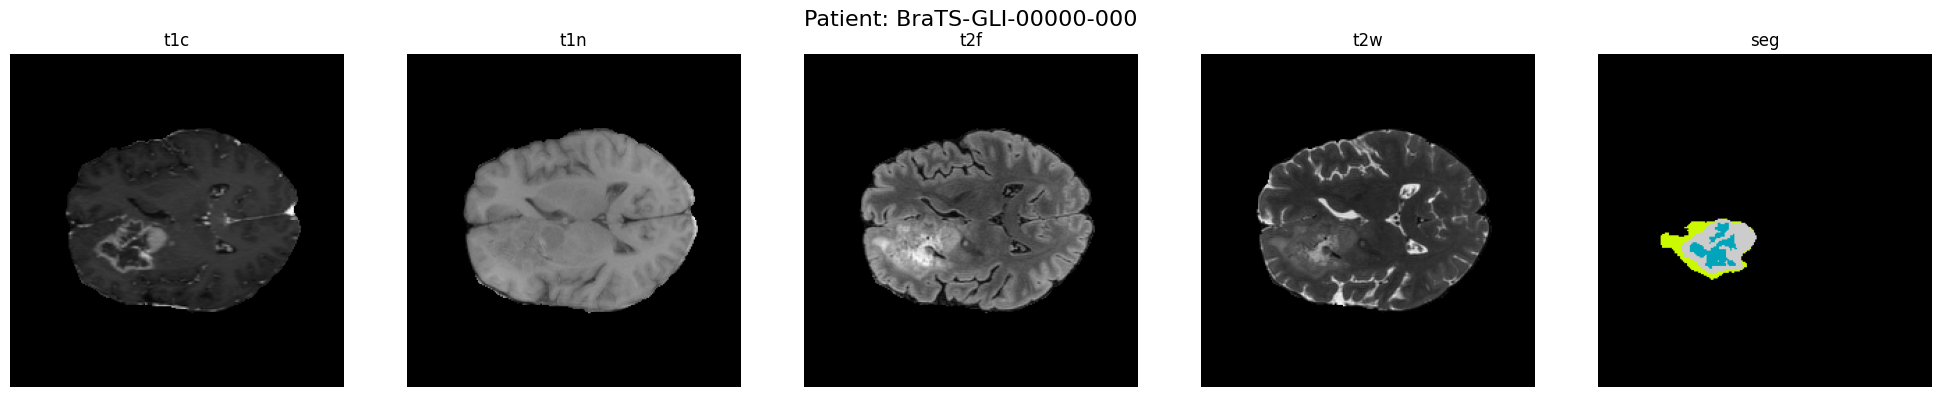

In [3]:
# Step 3: Analyze one patient from train/
import nibabel as nib
import matplotlib.pyplot as plt
import os

extract_path = "/content/drive/MyDrive/DL 3D Resnet Findings"

# Path to the extracted patient folder
patient_id = "BraTS-GLI-00000-000"
patient_path = os.path.join(extract_path, "dl_data_final", "train", patient_id)

# Modalities
modalities = ["t1c", "t1n", "t2f", "t2w", "seg"]
images = {}

# Load the modalities
for mod in modalities:
    file_path = os.path.join(patient_path, f"{patient_id}-{mod}.nii.gz")
    try:
        img = nib.load(file_path)
        images[mod] = img.get_fdata()
    except Exception as e:
        print(f"❌ Could not load {mod}: {e}")
        images[mod] = None

# Visualize axial mid-slice
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, mod in enumerate(modalities):
    ax = axes[i]
    img = images[mod]
    if img is not None:
        mid = img.shape[2] // 2
        cmap = "nipy_spectral" if mod == "seg" else "gray"
        ax.imshow(img[:, :, mid], cmap=cmap)
        ax.set_title(mod)
    else:
        ax.text(0.5, 0.5, "Load error", ha="center", va="center")
    ax.axis("off")

plt.suptitle(f"Patient: {patient_id}", fontsize=16)
plt.tight_layout()
plt.show()


# Validating Training Set
##(Making sure the data is clean and we do not have any bad inputs, ex NaN, Infs or Zeros values)



In [4]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os

train_dir = "/content/drive/MyDrive/DL 3D Resnet Findings/dl_data_final/train"
modalities = ["t1c", "t1n", "t2f", "t2w", "seg"]

###0 Function to validate one patient
def validate_patient(patient_id):
    patient_path = os.path.join(train_dir, patient_id)
    shapes = []
    issues = []

    for mod in modalities:
        path = os.path.join(patient_path, f"{patient_id}-{mod}.nii.gz")
        if not os.path.exists(path):
            issues.append(f"{mod} missing")
            continue

        try:
            img = nib.load(path)
            data = img.get_fdata()

            # Shape check
            shapes.append(data.shape)

            # Data checks
            if np.isnan(data).any():
                issues.append(f"{mod} has NaNs")
            if np.isinf(data).any():
                issues.append(f"{mod} has Infs")
            if np.all(data == 0):
                issues.append(f"{mod} is all zeros")

            # Seg label check
            if mod == "seg":
                unique_vals = np.unique(data)
                if not np.all(np.isin(unique_vals, [0, 1, 2, 3])):  # Adjust if needed
                    issues.append(f"seg has invalid labels: {unique_vals}")

        except Exception as e:
            issues.append(f"Error loading {mod}: {e}")

    # Check shape consistency
    if len(set(shapes)) > 1:
        issues.append(f"Shape mismatch: {shapes}")

    return issues

In [ ]:
# Running takes about 1hr 30 mins. Validates if all patient scan details are fine. NO NEED TO RUN AGAIN
# Validating all patients
# patients = sorted([
#     f for f in os.listdir(train_dir)
#     if not f.startswith('.') and os.path.isdir(os.path.join(train_dir, f))
# ])

# print("🔍 Validating training data...\n")
# for pid in patients:
#     issues = validate_patient(pid)
#     if issues:
#         print(f"⚠️ {pid} has issues:")
#         for issue in issues:
#             print("   -", issue)
#     else:
#         print(f"✅ {pid} is clean")


🔍 Validating training data...

✅ BraTS-GLI-00000-000 is clean
✅ BraTS-GLI-00002-000 is clean
✅ BraTS-GLI-00003-000 is clean
✅ BraTS-GLI-00005-000 is clean
✅ BraTS-GLI-00006-000 is clean
✅ BraTS-GLI-00008-000 is clean
✅ BraTS-GLI-00008-001 is clean
✅ BraTS-GLI-00009-000 is clean
✅ BraTS-GLI-00009-001 is clean
✅ BraTS-GLI-00012-000 is clean
✅ BraTS-GLI-00014-000 is clean
✅ BraTS-GLI-00014-001 is clean
✅ BraTS-GLI-00016-000 is clean
✅ BraTS-GLI-00016-001 is clean
✅ BraTS-GLI-00017-000 is clean
✅ BraTS-GLI-00017-001 is clean
✅ BraTS-GLI-00019-000 is clean
✅ BraTS-GLI-00020-000 is clean
✅ BraTS-GLI-00020-001 is clean
✅ BraTS-GLI-00021-000 is clean
✅ BraTS-GLI-00021-001 is clean
✅ BraTS-GLI-00022-000 is clean
✅ BraTS-GLI-00022-001 is clean
✅ BraTS-GLI-00024-000 is clean
✅ BraTS-GLI-00024-001 is clean
✅ BraTS-GLI-00025-000 is clean
✅ BraTS-GLI-00026-000 is clean
✅ BraTS-GLI-00030-000 is clean
✅ BraTS-GLI-00031-000 is clean
✅ BraTS-GLI-00031-001 is clean
✅ BraTS-GLI-00033-000 is clean
✅ BraTS-

# Pytorch Dataset and DataLoader


In [ ]:
### CODE FOR DELETING ALL .NPY FILES

# import os

# # Change this to your Drive path (e.g. inside MyDrive)
# root_dir = '/content/drive/MyDrive'

# # Loop through all files and delete .npy
# deleted = 0
# for dirpath, _, filenames in os.walk(root_dir):
#     for file in filenames:
#         if file.endswith('.npy'):
#             file_path = os.path.join(dirpath, file)
#             os.remove(file_path)
#             print(f"Deleted: {file_path}")
#             deleted += 1

# print(f"\n✅ Deleted {deleted} .npy files.")



✅ Deleted 0 .npy files.


In [5]:
import os
import torch
from torch.utils.data import Dataset
import nibabel as nib
import numpy as np

class BraTSDataset(Dataset):
    def __init__(self, root_dir, patient_ids, modalities=["t1c", "t1n", "t2f", "t2w"], transform=None):
        self.root_dir = root_dir
        self.patient_ids = patient_ids
        self.modalities = modalities
        self.transform = transform

    # helper function
    def normalize(self, vol):
        mean = np.mean(vol)
        std = np.std(vol)
        return (vol - mean) / std if std != 0 else vol


    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        pid = self.patient_ids[idx]
        patient_path = os.path.join(self.root_dir, pid)

        # Load & normalize each modality
        channels = []
        for mod in self.modalities:
            file_path = os.path.join(patient_path, f"{pid}-{mod}.nii.gz")
            img = nib.load(file_path).get_fdata()
            img = self.normalize(img)
            channels.append(img)

        # Stack modalities into [4, D, H, W]
        image = np.stack(channels, axis=0).astype(np.float32)

        # Load segmentation mask [D, H, W]
        mask_path = os.path.join(patient_path, f"{pid}-seg.nii.gz")
        mask = nib.load(mask_path).get_fdata().astype(np.uint8)

        # Convert to tensors
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        return image, mask


In [11]:
from torch.utils.data import DataLoader, random_split

# Path to raw .nii.gz dataset
train_path = "/content/drive/MyDrive/DL 3D Resnet Findings/dl_data_final/train"

# Get patient list
all_patients = sorted([
    f for f in os.listdir(train_path)
    if not f.startswith('.') and os.path.isdir(os.path.join(train_path, f))
])


# 80-20 train-val split
total_patients = len(all_patients)
split_index = int(0.8 * total_patients)

train_patients = all_patients[:split_index]
val_patients = all_patients[split_index:]

# Instantiate datasets
train_dataset = BraTSDataset(train_path, train_patients)
val_dataset = BraTSDataset(train_path, val_patients)

# DataLoaders (GPU-ready)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2, pin_memory=True)


# 3D ResNet Model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm3d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)

class ResNet3DSeg(nn.Module):
    def __init__(self, in_channels=4, num_classes=4):
        super(ResNet3DSeg, self).__init__()
        self.enc1 = BasicBlock3D(in_channels, 32)
        self.enc2 = BasicBlock3D(32, 64, stride=2)
        self.enc3 = BasicBlock3D(64, 128, stride=2)
        self.enc4 = BasicBlock3D(128, 256, stride=2)

        self.up3 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.dec3 = BasicBlock3D(128, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.dec2 = BasicBlock3D(64, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec1 = BasicBlock3D(32, 32)

        self.final = nn.Conv3d(32, num_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)

        x = self.up3(x4)
        x = self.dec3(x)
        x = self.up2(x)
        x = self.dec2(x)
        x = self.up1(x)
        x = self.dec1(x)

        return self.final(x)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet3DSeg(in_channels=4, num_classes=4).to(device)


##1. Dice Loss Implementation

In [19]:
import torch.nn as nn
import torch.nn.functional as F

def center_crop_to_match(pred, target):
    _, _, Dp, Hp, Wp = pred.shape
    Dt, Ht, Wt = target.shape[1:]

    dz = (Dp - Dt) // 2
    dy = (Hp - Ht) // 2
    dx = (Wp - Wt) // 2

    return pred[:, :, dz:dz+Dt, dy:dy+Ht, dx:dx+Wt]

class DiceCELoss(nn.Module):
    def __init__(self, weight=None, smooth=1e-5):
        super(DiceCELoss, self).__init__()
        self.ce = nn.CrossEntropyLoss(weight=weight)
        self.smooth = smooth

    def forward(self, logits, targets):
        targets = targets.long()
        logits = center_crop_to_match(logits, targets)

        # Cross Entropy Loss
        ce_loss = self.ce(logits, targets)

        # Dice Loss
        num_classes = logits.shape[1]
        probs = torch.softmax(logits, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes).permute(0, 4, 1, 2, 3).float()

        dims = (0, 2, 3, 4)
        intersection = torch.sum(probs * targets_one_hot, dims)
        union = torch.sum(probs + targets_one_hot, dims)

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1. - dice.mean()

        return 0.5 * ce_loss + 0.5 * dice_loss



## 2. Training & Validation Loops

In [20]:
from tqdm import tqdm
from torch.amp import autocast, GradScaler
scaler = GradScaler(device='cuda')

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for X, y in tqdm(dataloader, desc="🔁 Training", leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        with autocast(device_type="cuda"):  # ✅ Fixed here
            outputs = model(X)
            loss = criterion(outputs, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    return running_loss / len(dataloader)



def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="📏 Validating", leave=False):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            running_loss += loss.item()

    return running_loss / len(dataloader)



## 3. Train the Model

In [21]:
###

import os
from torch.optim import Adam

checkpoint_path = "/content/drive/MyDrive/DL 3D Resnet Findings/checkpoint_latest.pth"

# Re-initialize model, optimizer, scaler
model = ResNet3DSeg(in_channels=4, num_classes=4).to(device)
criterion = DiceCELoss()
optimizer = Adam(model.parameters(), lr=2e-4)
scaler = GradScaler(device='cuda')

# Resume from checkpoint if it exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"🔁 Resuming from epoch {start_epoch}")
else:
    start_epoch = 0
    print("🆕 Starting from scratch")


🆕 Starting from scratch


In [22]:
EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    print(f"\n📚 Epoch {epoch+1}/{EPOCHS}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)
    print(f"✅ Train Loss: {train_loss:.4f} | 🔍 Val Loss: {val_loss:.4f}")

    # 🔒 Save checkpoint after each epoch
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict()
    }
    torch.save(checkpoint, checkpoint_path)



📚 Epoch 1/50


✅ Train Loss: 0.3552 | 🔍 Val Loss: 0.2535

📚 Epoch 2/50


✅ Train Loss: 0.1905 | 🔍 Val Loss: 0.2097

📚 Epoch 3/50


✅ Train Loss: 0.1412 | 🔍 Val Loss: 0.1980

📚 Epoch 4/50


✅ Train Loss: 0.1207 | 🔍 Val Loss: 0.1838

📚 Epoch 5/50


✅ Train Loss: 0.1122 | 🔍 Val Loss: 0.1821

📚 Epoch 6/50


✅ Train Loss: 0.1033 | 🔍 Val Loss: 0.1559

📚 Epoch 7/50


✅ Train Loss: 0.0998 | 🔍 Val Loss: 0.1584

📚 Epoch 8/50


✅ Train Loss: 0.0932 | 🔍 Val Loss: 0.1478

📚 Epoch 9/50


✅ Train Loss: 0.0916 | 🔍 Val Loss: 0.1547

📚 Epoch 10/50


✅ Train Loss: 0.0912 | 🔍 Val Loss: 0.2004

📚 Epoch 11/50


✅ Train Loss: 0.0891 | 🔍 Val Loss: 0.1447

📚 Epoch 12/50


✅ Train Loss: 0.0880 | 🔍 Val Loss: 0.1490

📚 Epoch 13/50


✅ Train Loss: 0.0832 | 🔍 Val Loss: 0.1470

📚 Epoch 14/50


✅ Train Loss: 0.0794 | 🔍 Val Loss: 0.1427

📚 Epoch 15/50


✅ Train Loss: 0.0794 | 🔍 Val Loss: 0.1492

📚 Epoch 16/50


✅ Train Loss: 0.0784 | 🔍 Val Loss: 0.1430

📚 Epoch 17/50


✅ Train Loss: 0.0795 | 🔍 Val Loss: 0.1427

📚 Epoch 18/50


✅ Train Loss: 0.0768 | 🔍 Val Loss: 0.1378

📚 Epoch 19/50


✅ Train Loss: 0.0737 | 🔍 Val Loss: 0.1394

📚 Epoch 20/50


✅ Train Loss: 0.0737 | 🔍 Val Loss: 0.1373

📚 Epoch 21/50


✅ Train Loss: 0.0717 | 🔍 Val Loss: 0.1318

📚 Epoch 22/50


✅ Train Loss: 0.0732 | 🔍 Val Loss: 0.1459

📚 Epoch 23/50


✅ Train Loss: 0.0712 | 🔍 Val Loss: 0.1395

📚 Epoch 24/50


✅ Train Loss: 0.0699 | 🔍 Val Loss: 0.1376

📚 Epoch 25/50


✅ Train Loss: 0.0672 | 🔍 Val Loss: 0.1329

📚 Epoch 26/50


✅ Train Loss: 0.0700 | 🔍 Val Loss: 0.1324

📚 Epoch 27/50


✅ Train Loss: 0.0655 | 🔍 Val Loss: 0.1375

📚 Epoch 28/50


✅ Train Loss: 0.0649 | 🔍 Val Loss: 0.1326

📚 Epoch 29/50


✅ Train Loss: 0.0668 | 🔍 Val Loss: 0.1304

📚 Epoch 30/50


✅ Train Loss: 0.0641 | 🔍 Val Loss: 0.1362

📚 Epoch 31/50


✅ Train Loss: 0.0638 | 🔍 Val Loss: 0.1283

📚 Epoch 32/50


✅ Train Loss: 0.0627 | 🔍 Val Loss: 0.1386

📚 Epoch 33/50


✅ Train Loss: 0.0612 | 🔍 Val Loss: 0.1424

📚 Epoch 34/50


✅ Train Loss: 0.0600 | 🔍 Val Loss: 0.1275

📚 Epoch 35/50


✅ Train Loss: 0.0624 | 🔍 Val Loss: 0.1325

📚 Epoch 36/50


✅ Train Loss: 0.0631 | 🔍 Val Loss: 0.1271

📚 Epoch 37/50


✅ Train Loss: 0.0593 | 🔍 Val Loss: 0.1252

📚 Epoch 38/50


✅ Train Loss: 0.0608 | 🔍 Val Loss: 0.1354

📚 Epoch 39/50


✅ Train Loss: 0.0588 | 🔍 Val Loss: 0.1364

📚 Epoch 40/50


✅ Train Loss: 0.0582 | 🔍 Val Loss: 0.1300

📚 Epoch 41/50


✅ Train Loss: 0.0555 | 🔍 Val Loss: 0.1184

📚 Epoch 42/50


✅ Train Loss: 0.0552 | 🔍 Val Loss: 0.1292

📚 Epoch 43/50


✅ Train Loss: 0.0544 | 🔍 Val Loss: 0.1284

📚 Epoch 44/50


✅ Train Loss: 0.0549 | 🔍 Val Loss: 0.1253

📚 Epoch 45/50


✅ Train Loss: 0.0574 | 🔍 Val Loss: 0.1306

📚 Epoch 46/50


✅ Train Loss: 0.0553 | 🔍 Val Loss: 0.1339

📚 Epoch 47/50


✅ Train Loss: 0.0525 | 🔍 Val Loss: 0.1277

📚 Epoch 48/50


✅ Train Loss: 0.0514 | 🔍 Val Loss: 0.1213

📚 Epoch 49/50


✅ Train Loss: 0.0529 | 🔍 Val Loss: 0.1258

📚 Epoch 50/50


✅ Train Loss: 0.0523 | 🔍 Val Loss: 0.1290


In [ ]:
## Saving the model

torch.save(model.state_dict(), "/content/drive/MyDrive/DL 3D Resnet Findings/3dresnet_model.pth")
print("✅ Model saved!")

✅ Model saved!


In [ ]:
model = ResNet3DSeg(in_channels=4, num_classes=4).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/DL 3D Resnet Findings/3dresnet_model.pth"))
model.eval()
print("✅ Model loaded and ready for inference!")

## In future if ever need to use it again, just do the following:
# model = ResNet3DSeg(in_channels=4, num_classes=4).to(device)
# model.load_state_dict(torch.load("/content/drive/MyDrive/DL 3D Resnet Findings/3dresnet_model.pth"))
# model.eval()
# with torch.no_grad():
#     for X, y in test_loader:  # or any new data
#         X = X.to(device)
#         output = model(X)
#         prediction = torch.argmax(output, dim=1)  # [B, D, H, W]


✅ Model loaded and ready for inference!


# Evaluate the Model on the Test Set

##  Setup Test Dataset & DataLoader

In [ ]:
test_path = "/content/drive/MyDrive/DL 3D Resnet Findings/dl_data_final/test"

test_patients = sorted([
    f for f in os.listdir(test_path)
    if not f.startswith('.') and os.path.isdir(os.path.join(test_path, f))
])

test_dataset = BraTSDataset(test_path, test_patients)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)


## Dice Score Function (Inference version)

In [ ]:
def compute_dice_score(pred, target, num_classes=4, smooth=1e-5):
    pred = torch.argmax(pred, dim=1)  # [B, D, H, W]
    scores = []

    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()

        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice = (2 * intersection + smooth) / (union + smooth)
        scores.append(dice.item())

    return scores  # List of dice scores per class


## Run Inference on Test Set

In [ ]:
model.eval()
all_scores = []

with torch.no_grad():
    for X, y in tqdm(test_loader, desc="🧪 Evaluating on Test Set"):
        X, y = X.to(device), y.to(device)

        with autocast(device_type="cuda"):
            logits = model(X)

        logits = center_crop_to_match(logits, y)  # ensure output shape matches mask
        scores = compute_dice_score(logits, y)
        all_scores.append(scores)

# Results
import numpy as np
all_scores = np.array(all_scores)
mean_dice_per_class = np.mean(all_scores, axis=0)

for i, dice in enumerate(mean_dice_per_class):
    print(f"🎯 Dice Score (Class {i}): {dice:.4f}")

print(f"\n🧠 Mean Dice Score across all classes: {np.mean(mean_dice_per_class):.4f}")


🧪 Evaluating on Test Set: 100%|██████████| 241/241 [13:02<00:00,  3.25s/it]

🎯 Dice Score (Class 0): 0.9979
🎯 Dice Score (Class 1): 0.6391
🎯 Dice Score (Class 2): 0.7476
🎯 Dice Score (Class 3): 0.7528

🧠 Mean Dice Score across all classes: 0.7844
